In [40]:
# import the necessary modules
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [4]:
basket_items = pd.read_csv("groceries_basket.csv")
basket_items.head()

,order_id,product_id,product_name,category,add_to_cart_sequence_index
0,1,49302,Bulgarian Yogurt,dairy eggs,1
1,1,10246,Organic Celery Hearts,produce,2
2,1,43633,Lightly Smoked Sardines in Olive Oil,canned goods,3
3,1,13176,Bag of Organic Bananas,produce,4
4,1,47209,Organic Hass Avocado,produce,5


In [5]:
# items
n_items = basket_items['product_id'].nunique()
print(f'Number of unique items: {n_items}')
# orders
n_orders = basket_items['order_id'].nunique()
print(f'Number of unique orders: {n_orders}')
# basket_items
n_basket_items = len(basket_items)
print(f'Number of basket items: {n_basket_items}')

Number of unique items: 26548
Number of unique orders: 64864
Number of basket items: 573124


In [6]:
product_lookup = (
    basket_items[["product_id", "product_name"]]
    .drop_duplicates()
    .set_index("product_id")
)

# a) Product Frequencies

In [7]:
product_support = (
    basket_items
    .groupby("product_id")["order_id"]
    .nunique()
    .rename("support")
    .reset_index()
)

In [8]:
mean_support = product_support["support"].mean()
median_support = product_support["support"].median()

In [9]:
print(f"1. A product must be ordered {0.01*n_orders} times to have required support")
print(f"2. Mean support count: {mean_support:g}")
print(f"3. Median support count: {median_support:g}")


1. A product must be ordered 648.64 times to have required support
2. Mean support count: 21.5882
3. Median support count: 4


# b) + c) Most frequent Products

In [10]:
top_10 = product_support.sort_values(['support'],ascending=False).head(10)
top_10['relative_support'] = top_10['support'] / n_orders
top_10

,product_id,support,relative_support
13273,24852,9376,0.144549
7039,13176,7701,0.118725
11292,21137,5480,0.084484
11720,21903,4818,0.074278
25430,47626,4096,0.063148
25513,47766,3670,0.056580
25212,47209,3605,0.055578
8967,16797,3199,0.049319
13962,26209,3017,0.046513
14896,27966,2728,0.042057


In [11]:
print(f"Top 10 most frequent product IDs: \n{top_10['product_id'].tolist()}")

Top 10 most frequent product IDs: 
[24852, 13176, 21137, 21903, 47626, 47766, 47209, 16797, 26209, 27966]


In [12]:
max_support_size_3 = top_10["support"].iloc[:3].min()
max_support_size_3

5480

In [13]:
itemset_3 = top_10["product_id"].iloc[:3].tolist()
itemset_3

[24852, 13176, 21137]

The maximum support that an itemset of size 3 can achieve is 0.084484.
This upper bound is obtained by choosing the three most frequent products:
24852, 13176, and 21137.

In [14]:
target_products = {24852, 13176, 21137}

orders_with_all_3 = (
    basket_items
    .groupby("order_id")["product_id"]
    .apply(lambda x: target_products.issubset(set(x)))
    .sum()
)

int(orders_with_all_3)

3

In [15]:
product_lookup.loc[[24852, 13176, 21137]]

,product_name
product_id,
24852,Banana
13176,Bag of Organic Bananas
21137,Organic Strawberries


Although all three products are individually very frequent, only a small number of orders contain all three simultaneously. This is because customers often purchase only a subset of staple items per order, and even popular products do not necessarily co-occur in the same shopping basket.

# d) + e) Product Categories

You don't really need the notebook for e)

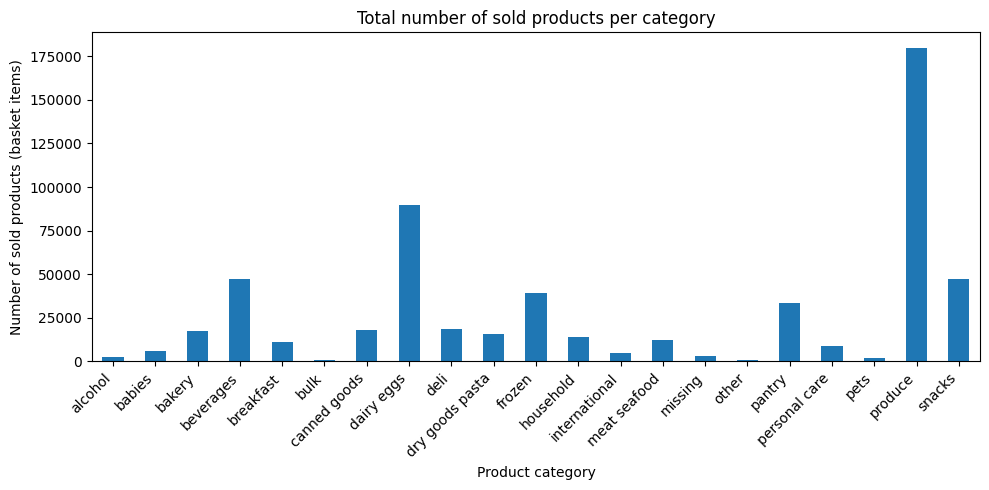

In [16]:
# total number of sold items per category
items_per_category = (
    basket_items
    .groupby("category")
    .size()
    .sort_index()   # alphabetical order
)

plt.figure(figsize=(10, 5))
items_per_category.plot(kind="bar")
plt.ylabel("Number of sold products (basket items)")
plt.xlabel("Product category")
plt.title("Total number of sold products per category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

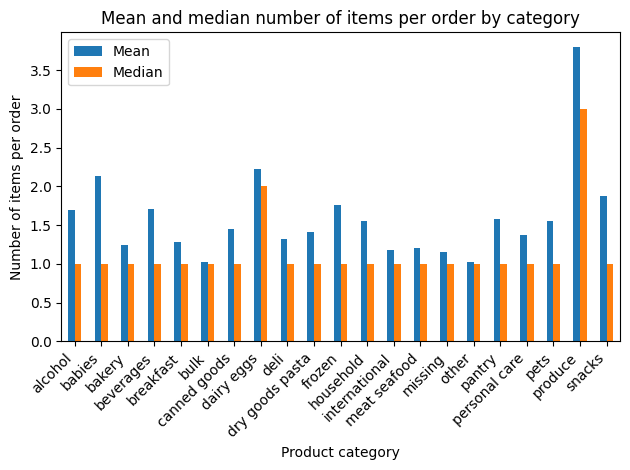

In [17]:
# count items per (order, category)
items_per_order_category = (
    basket_items
    .groupby(["order_id", "category"])
    .size()
    .reset_index(name="count")
)

# mean and median per category
stats_per_category = (
    items_per_order_category
    .groupby("category")["count"]
    .agg(mean="mean", median="median")
    .sort_index()   # alphabetical order
)
plt.figure(figsize=(10, 5))
stats_per_category.plot(kind="bar")
plt.ylabel("Number of items per order")
plt.xlabel("Product category")
plt.title("Mean and median number of items per order by category")
plt.xticks(rotation=45, ha="right")
plt.legend(["Mean", "Median"])
plt.tight_layout()
plt.show()

For beverages, the mean number of items per order is noticeably higher than the median, indicating a right-skewed distribution. This suggests that while most orders contain only one beverage item, a smaller number of orders include multiple beverage products, which increases the mean. Such behavior is consistent with bulk or stock-up purchases of drinks.

# f) Frequent Itemsets

In [18]:
# use the provided frequent itemsets.
frequent_itemsets = pd.read_csv('frequent_itemsets.csv')
# format frozensets
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: frozenset(eval(x)))
frequent_itemsets.head()

,support,itemsets
0,0.118725,(13176)
1,0.055578,(47209)
2,0.015432,(22035)
3,0.008048,(10246)
4,0.029462,(46979)


In [19]:
# size of each itemset
frequent_itemsets["size"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))

In [20]:
max_size = frequent_itemsets["size"].max()

largest_itemsets = frequent_itemsets[frequent_itemsets["size"] == max_size]
max_size, len(largest_itemsets)

(4, 1)

In [21]:
product_lookup = (
    basket_items[["product_id", "product_name"]]
    .drop_duplicates()
    .set_index("product_id")["product_name"]
)

largest_itemset_names = [
    [product_lookup[i] for i in itemset]
    for itemset in largest_itemsets["itemsets"]
]

largest_itemset_names

[['Bag of Organic Bananas',
  'Organic Hass Avocado',
  'Organic Strawberries',
  'Organic Raspberries']]

In [22]:
print(f"The largest frequent itemset contains {max_size} products.\n The products in this itemset are: \n{largest_itemset_names}.")

The largest frequent itemset contains 4 products.
 The products in this itemset are: 
[['Bag of Organic Bananas', 'Organic Hass Avocado', 'Organic Strawberries', 'Organic Raspberries']].


In [23]:
freq_ge_2 = frequent_itemsets[frequent_itemsets["size"] >= 2]

absolute_count = len(freq_ge_2)
relative_count = absolute_count / len(frequent_itemsets)

print(f"There are {absolute_count} frequent itemsets of size 2 or larger, \ncorresponding to {relative_count:.2%} of all frequent itemsets.")

There are 1017 frequent itemsets of size 2 or larger, 
corresponding to 51.47% of all frequent itemsets.


In [24]:
from collections import Counter

item_counter = Counter()

for itemset in frequent_itemsets["itemsets"]:
    item_counter.update(itemset)

most_common_item, count = item_counter.most_common(1)[0]

print(f"The product {product_lookup[most_common_item]} appears in the most frequent itemsets, occurring in {count} frequent itemsets.")

The product Banana appears in the most frequent itemsets, occurring in 168 frequent itemsets.


In [25]:
single_occurrence_products = [
    item for item, c in item_counter.items() if c == 1
]

print(f"{len(single_occurrence_products)} products appear in only a single frequent itemset.")

794 products appear in only a single frequent itemset.


# g) + h) Category Sets

You don't really need the notebook for h)

In [26]:
# product_id -> category lookup
product_to_category = (
    basket_items[["product_id", "category"]]
    .drop_duplicates()
    .set_index("product_id")["category"]
)
# restrict to frequent itemsets of size ≥ 2
freq_ge_2 = frequent_itemsets[frequent_itemsets["size"] >= 2].copy()
# map each itemset to a category set
freq_ge_2["category_set"] = freq_ge_2["itemsets"].apply(
    lambda items: frozenset(product_to_category[i] for i in items)
)

In [27]:
# count category-set frequencies
category_set_counts = (
    freq_ge_2
    .groupby("category_set")
    .size()
    .sort_values(ascending=False)
)

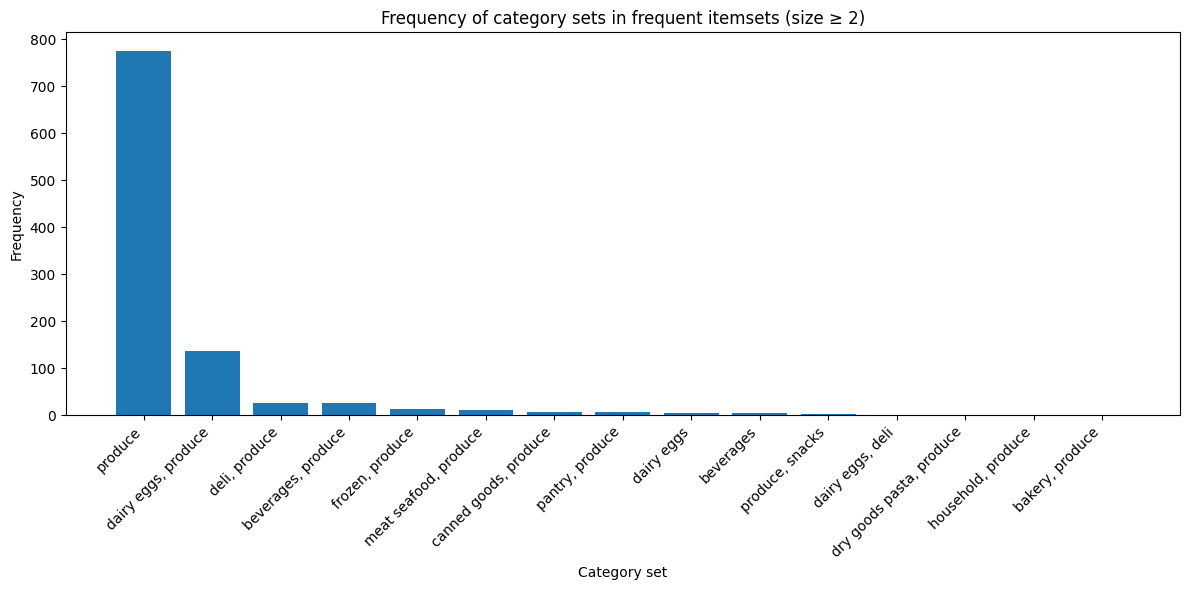

In [28]:
# make category sets readable (labels)
category_set_labels = [
    ", ".join(sorted(cat_set)) for cat_set in category_set_counts.index
]
plt.figure(figsize=(12, 6))
plt.bar(category_set_labels, category_set_counts.values)
plt.ylabel("Frequency")
plt.xlabel("Category set")
plt.title("Frequency of category sets in frequent itemsets (size ≥ 2)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Observation 1**
This is not unexpected because produce items have the highest individual support and are purchased very frequently across many orders. Since frequent itemsets are constrained by minimum support, combinations of high-support produce items are much more likely to remain frequent than combinations involving less frequently purchased categories.

**Observation 2**
Produce products appear in most orders and co-occur with many other product categories, which makes them natural “connectors” in frequent itemsets. As a result, they survive the support threshold even when combined with less frequent products, explaining their near-ubiquitous presence.

**Observation 3**
This is not surprising because beverage purchases, while less common overall, often involve buying multiple beverage items together (e.g., several drinks at once), leading to strong co-occurrence within that category. This implies that the sold beverages exhibit high intra-category diversity, with multiple beverage products being frequently bought together even if beverages are absent from many other orders.

# i) Association Rules and Frequent Items

In [29]:
frequent_itemsets['itemsets']

,itemsets
0,(13176)
1,(47209)
2,(22035)
3,(10246)
4,(46979)
...,...
1971,"(46906, 47766)"
1972,"(46906, 24852)"
1973,"(46906, 21903)"
1974,"(18523, 24852)"


In [30]:
# determine rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules = rules.drop(columns=["representativity", "leverage", "conviction", "zhangs_metric", "jaccard", "certainty", "kulczynski"])
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(47209),(13176),0.055578,0.118725,0.018423,0.331484,2.792025
1,(47209),(21137),0.055578,0.084484,0.011486,0.206657,2.446100
2,"(13176, 47209)",(21137),0.018423,0.084484,0.005396,0.292887,3.466756
3,"(13176, 21137)",(47209),0.023942,0.055578,0.005396,0.225370,4.055039
4,"(47209, 21137)",(13176),0.011486,0.118725,0.005396,0.469799,3.957021


In [31]:
mean_lift = rules["lift"].mean()
median_lift = rules["lift"].median()

print(f"Mean lift:   {mean_lift:.4f}")
print(f"Median lift: {median_lift:.4f}")

Mean lift:   3.9534
Median lift: 2.8310


In [32]:
top10_ids = set(top_10["product_id"].tolist())
top10_ids

{13176, 16797, 21137, 21903, 24852, 26209, 27966, 47209, 47626, 47766}

In [33]:
n_rules_top10_in_antecedent = rules["antecedents"].apply(
    lambda s: len(s.intersection(top10_ids)) > 0
).sum()

n_rules_top10_in_antecedent

np.int64(228)

In [34]:
n_rules_top10_in_consequent = rules["consequents"].apply(
    lambda s: len(s.intersection(top10_ids)) > 0
).sum()

n_rules_top10_in_consequent

np.int64(430)

# j) Confidence

In [35]:
# rule with maximum confidence
best_rule = rules.loc[rules["confidence"].idxmax()]
antecedent_names = [product_lookup[i] for i in best_rule["antecedents"]]
consequent_names = [product_lookup[i] for i in best_rule["consequents"]]

antecedent_names, consequent_names, best_rule["confidence"], best_rule["lift"]

(['Organic Hass Avocado', 'Organic Strawberries', 'Organic Raspberries'],
 ['Bag of Organic Bananas'],
 np.float64(0.6224489795918181),
 np.float64(5.242764655530932))

**Interpretation of the highest-confidence rule**

The association rule has the highest confidence, meaning that when the products in the antecedent are purchased, the consequent product is bought with very high probability. This indicates a strong conditional relationship, although it does not necessarily imply a strong increase in purchase likelihood beyond the product’s overall popularity.

**Why the most frequent product appears as the consequent**

It is not unexpected that the most frequent product appears as the consequent because highly popular products already occur in a large fraction of orders, which naturally leads to high conditional probabilities. Placing such a product in the antecedent would instead restrict the rule to many orders where the consequent is not present, lowering confidence. Therefore, frequent products tend to maximize confidence when used as consequents rather than antecedents.

# k) No very frequent products, Lift

In [36]:
# rules that contain NONE of the top-10 products in antecedent or consequent
mask_no_top10 = rules.apply(
    lambda r: (len(r["antecedents"].intersection(top10_ids)) == 0) and
              (len(r["consequents"].intersection(top10_ids)) == 0),
    axis=1
)

rules_no_top10 = rules[mask_no_top10].copy()

print(f"Total rules: {len(rules)}")
print(f"Rules with NO top-10 in antecedent or consequent: {len(rules_no_top10)} "
      f"({len(rules_no_top10)/len(rules):.2%})\n")

def lift_summary(df, name):
    lifts = df["lift"].dropna()
    print(f"{name}:")
    print(f"  mean lift   = {lifts.mean():.4f}")
    print(f"  median lift = {lifts.median():.4f}")
    print("  quantiles   = " +
          ", ".join([f"{q:.0%}:{lifts.quantile(q):.4f}" for q in [0.10, 0.25, 0.50, 0.75, 0.90]]))
    print(f"  max lift    = {lifts.max():.4f}\n")

lift_summary(rules, "All rules")
lift_summary(rules_no_top10, "Rules excluding top-10 products")

Total rules: 453
Rules with NO top-10 in antecedent or consequent: 16 (3.53%)

All rules:
  mean lift   = 3.9534
  median lift = 2.8310
  quantiles   = 10%:1.6785, 25%:2.0210, 50%:2.8310, 75%:3.8676, 90%:5.5410
  max lift    = 73.4109

Rules excluding top-10 products:
  mean lift   = 26.9801
  median lift = 10.9025
  quantiles   = 10%:6.6665, 25%:9.3803, 50%:10.9025, 75%:47.4371, 90%:60.5093
  max lift    = 73.4109



The association rules that do not contain any of the top-10 most frequent products have a dramatically higher lift than the overall set of rules, with both mean and median lift being an order of magnitude larger. This is not surprising because rules involving less frequent products often capture strong, specific co-occurrence patterns, which leads to high lift despite lower absolute support. In contrast, highly frequent products tend to co-occur with many items by chance, which inflates confidence but suppresses lift.

# l) Sub-sequences

In [37]:
# function from the exercise notebook
def contained(is_seq1, is_seq2):
    size1 = len(is_seq1)
    size2 = len(is_seq2)

    if size1 > size2:
        return False

    last_1 = 0
    last_2 = 0

    while last_1 < size1 and last_2 < size2:
        item1 = is_seq1[last_1]
        item2 = is_seq2[last_2]
        if item1 == item2:
            last_1 += 1
        last_2 += 1

    if last_1 == size1:
        return True
    else:
        return False

In [38]:
from itertools import combinations

# --- Step 1: extract single-item rules ---
single_item_rules = rules[
    (rules["antecedents"].apply(len) == 1) &
    (rules["consequents"].apply(len) == 1)
]

# normalize rules into (a, b) pairs
rule_pairs = set(
    (next(iter(a)), next(iter(b)))
    for a, b in zip(single_item_rules["antecedents"], single_item_rules["consequents"])
)

# --- Step 2: keep only bidirectional pairs (a->b and b->a) ---
bidirectional_pairs = {
    tuple(sorted((a, b)))
    for (a, b) in rule_pairs
    if (b, a) in rule_pairs
}

bidirectional_pairs

{(4957, 33754), (13176, 21137), (28465, 36865), (33754, 33787)}

In [39]:
# --- Step 3: build order → ordered product sequence ---
order_sequences = (
    basket_items
    .sort_values("add_to_cart_sequence_index")
    .groupby("order_id")["product_id"]
    .apply(list)
)
# --- Step 4: compute subsequence support counts ---
rows = []

for a, b in bidirectional_pairs:
    count_a_then_b = 0
    count_b_then_a = 0

    for seq in order_sequences:
        if contained([a, b],seq):
            count_a_then_b += 1
        if contained([b, a],seq):
            count_b_then_a += 1

    rows.append({
        "product_a": a,
        "product_b": b,
        "support_<a,b>": count_a_then_b,
        "support_<b,a>": count_b_then_a
    })

subsequence_support_table = pd.DataFrame(rows)
subsequence_support_table

,product_a,product_b,"support_<a,b>","support_<b,a>"
0,4957,33754,53,57
1,28465,36865,59,61
2,33754,33787,69,47
3,13176,21137,1149,404


# m) Rules with support count > 99, confidence > 0.2, Lift < 1

Lift is defined as

$$
\text{lift}(A \Rightarrow B) = \frac{\text{confidence}(A \Rightarrow B)}{\text{support}(B)}.
$$

From task (b), we know that no product in the dataset has a support larger than 0.2.
Given the constraint $\text{confidence}(A \Rightarrow B) > 0.2$, this implies that

$$
\text{lift}(A \Rightarrow B)
= \frac{\text{confidence}(A \Rightarrow B)}{\text{support}(B)}
> 1
$$

for all possible rules. Therefore, it is not possible to find an association rule that
simultaneously satisfies a support count
